In [1]:
#!pip install torch==1.9.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torch==1.9.1+cpu torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install torchaudio

In [1]:
#!pip install audtorch
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import os
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
import sklearn 

from IPython.display import clear_output
import tqdm.notebook as tqdm
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import Conv2dStaticSamePadding
from torch import nn
from sklearn.metrics import classification_report

import torch.nn.functional as F

#import audtorch
%matplotlib inline

In [3]:
from utils.dataloader import make_sorted_dataloader, collate_with_paddings
from utils.chunk_dataset import ChunkDataSet
from utils.zip_dataset import ZippedDataSet
from utils.chunk_augmented_dataset import ChunkAugDataSet
from utils.scan_data import scan_rootdir
import utils.load_data
from utils.load_data import load_anno_tensor, load_vad_df


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [224]:
!ls data/

Annotations_gold_standard-20220202T091454Z-001.zip
Data-20211102T111411Z-001.zip
Data-20211102T111411Z-002.zip
Data-20211102T111411Z-003.zip
ds_chunk2s.zip
ds_chunk400ms.zip
ds.zip
noises
NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data
NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data-20220322T103638Z-001.zip
trainds_chunk400ms_msl0.4.zip


In [225]:
s = utils.load_data.load_anno_tensor('data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/train/039_2016-04-07_Nottingham/annotation_expert.txt')


In [5]:
#train_ds = 
chunk_sz=6
DATA_BASEDIR="data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English"

train_ds = ZippedDataSet(f'{DATA_BASEDIR}/train_chunk{chunk_sz}s_msl0.zip', 
                         ChunkDataSet(f'{DATA_BASEDIR}/train/', chunk_size_s=chunk_sz), 
                         rewrite=False, 
                         min_sample_len=0)
dev_ds = ZippedDataSet(f'{DATA_BASEDIR}/dev_chunk{chunk_sz}s_msl0.zip', 
                        ChunkDataSet(f'{DATA_BASEDIR}/dev', chunk_size_s=chunk_sz), 
                        rewrite=False, 
                        min_sample_len=0)
test_ds = ZippedDataSet(f'{DATA_BASEDIR}/test_chunk{chunk_sz}s_msl0.zip', 
                        ChunkDataSet(f'{DATA_BASEDIR}/test', chunk_size_s=chunk_sz), 
                        rewrite=True, 
                        min_sample_len=0)

Didn't find ANNO for data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/train/039_2016-04-07_Nottingham novice.
2320 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/train_chunk6s_msl0.zip' exists! Using that archive
675 chunks
zip_fname='data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/dev_chunk6s_msl0.zip' exists! Using that archive
347 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/test_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (347 -> 347)


  0%|          | 0/347 [00:00<?, ?it/s]

675 chunks
generating data/NoXi_annotations_reliable_gold_standard_classification_with_additional_train_data/English/dev_chunk6s_msl0.zip.
Dataloader min_sample_len=0
SortedSampler remove 0 (675 -> 675)


  0%|          | 0/675 [00:00<?, ?it/s]

In [6]:
test_ds[0]['labels']

tensor([[0.0000, 0.2308, 0.7692, 0.0000, 0.0000]])

In [7]:
test_ds.feats_dim

40

In [8]:
test_ds.anno_dim

5

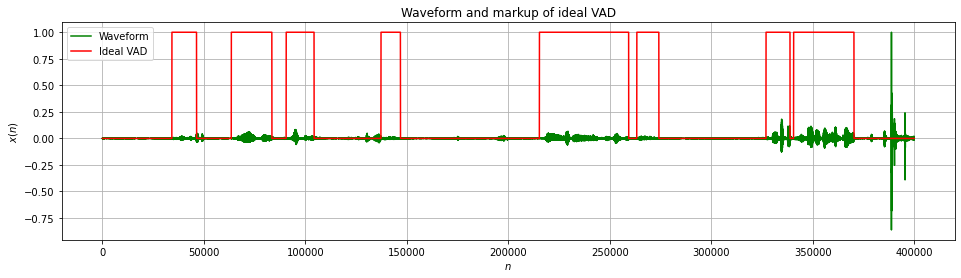

In [9]:

class EfficientNetASR(nn.Module):                                                                                                                                                                 
    def __init__(self, efficient_net_version='b0', num_cls=5, aug_prob=0.9):                                                                                                                                         
        super().__init__()
        assert efficient_net_version is not None
        self.aug_prob = aug_prob
        self.aug = nn.Sequential(torchaudio.transforms.TimeMasking(20), #12
                                        torchaudio.transforms.TimeMasking(20), #12
                                        torchaudio.transforms.FrequencyMasking(8),
                                        torchaudio.transforms.FrequencyMasking(8))
            
        self.efficientnet_model = EfficientNet.from_pretrained('efficientnet-%s' % efficient_net_version)                                                                                                                                                             
        self.efficientnet_model._conv_stem = Conv2dStaticSamePadding(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False, image_size=(128, 188))
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(1000, 256, bias=True)                                                                                                                                  
        self.head = nn.Linear(256, num_cls)
        self.sf = torch.nn.LogSoftmax(dim=-1)
        
    def forward(self, x):
        if self.training:
            p = random.random()
            if p <= self.aug_prob:    
                x = self.aug(x)
        else:
            x = self.aug(x)
        x = x.unsqueeze(dim=1)
        x = F.relu(self.efficientnet_model(x))
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.head(x)
        #print(x.shape)
        return self.sf(x)


In [10]:
def get_cls_weights(ds, num_classes=5):
    cls2num = torch.zeros(5)
    num=0
    for i in tqdm.tqdm(range(len(ds))):
        item = ds[i]
        cls2num += item['labels'].view(-1)
        num+=1
    return cls2num/num
print(f"Train labels distribution: {get_cls_weights(train_ds)}")
print(f"dev labels distribution: {get_cls_weights(dev_ds)}")
print(f"test labels distribution: {get_cls_weights(test_ds)}")

  0%|          | 0/2320 [00:00<?, ?it/s]

Train labels distribution: tensor([0.0041, 0.0150, 0.4626, 0.4274, 0.0909])


  0%|          | 0/675 [00:00<?, ?it/s]

dev labels distribution: tensor([0.0078, 0.0122, 0.1926, 0.5263, 0.2611])


  0%|          | 0/347 [00:00<?, ?it/s]

test labels distribution: tensor([0.0125, 0.0202, 0.2570, 0.6068, 0.1036])


In [11]:
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp).detach()
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [12]:
def get_criterion(train_ds, criterion='ce', device='cpu', gamma=1):
    if criterion == 'ce':
        weights = get_cls_weights(train_ds) ** gamma
        return nn.CrossEntropyLoss(weight=(1/weights).to(device), ignore_index=-1)
    if criterion == 'focal':
        return FocalLoss(gamma=focal_gamma)
    if criterion == 'kl':
        return nn.KLDivLoss(reduction='batchmean')
    
    

In [13]:
def eval_cls(model, dataloader, device='cpu', calc_report=True, criterion=None):
    model.eval()
    losses = []
    if criterion is None:
        criterion = nn.KLDivLoss(reduction='batchmean')
    truth = []
    predicted = [] 
    with torch.no_grad():
        for batch in dataloader:
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
            pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) 
            #print(logits.shape, y_batch.shape)
            loss = criterion(logits, y_batch)
            losses.append(loss.item())
            predicted.append(logits.argmax(dim=-1).cpu().numpy())
            truth.append(batch['labels'].argmax(dim=-1).cpu().numpy())
    cr = None
    conf_matrix = None
    if calc_report:
        truth = np.concatenate(truth)
        predicted = np.concatenate(predicted)
        labels = ['l1', 'l2', 'l3', 'l4', 'l5']
        cr = classification_report(truth, predicted, target_names=labels)
        conf_matrix = sklearn.metrics.confusion_matrix(truth, predicted)#, labels=labels)
    return np.mean(losses), cr, conf_matrix


        
def train_per_chunk(model, train_dl, val_dl, 
                    epochs=10, 
                    device='cpu', 
                    lr=1e-3, 
                    gamma=0.95,
                    weight_decay=1e-6,
                    criterion=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    if criterion is None:
        criterion = nn.KLDivLoss(reduction='batchmean')
    
    train_losses = []
    val_losses = []
    last_val = float('inf')
    t1 = tqdm.tqdm(range(1, epochs+1))
    best_val_loss = float('inf')
    for e in t1:
        #print(f'Epoch {e}/{epochs}')
        #tqdm.tqdm
        losses = []
        t2 = (train_dl)
        for batch in t2:
            model.train()
            x_batch = batch['feats'].to(device) #btz X feat_dim X seq_len
            y_batch = batch['labels'].to(device)
#             pad_batch = batch['padding'].to(device)
            #print(x_batch.shape, y_batch.shape)

            logits = model(x_batch) #* pad_batch         
            loss  = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

            t1.set_description(desc=f"Ep {e}, loss={losses[-1]:.5f}, val={last_val:.5f}")
            #break
        scheduler.step()
        train_losses.append(np.mean(losses))
        last_val, cr, _ = eval_cls(model, val_dl, device=device, criterion=criterion, calc_report=False)
        val_losses.append(last_val)
        if best_val_loss > last_val:
            torch.save(model, 'models/model.best.pt')
            best_val_loss = last_val
            print(f"Best val loss {last_val}")
        #print(cr)
        
    plt.figure(figsize=(8, 8)); plt.title('Train losses')
    plt.xlabel('iter') ; plt.ylabel('loss'); plt.grid()
    plt.plot(train_losses, label='train loss')
    val_losses = np.array(val_losses)
    val_losses[val_losses>2] = 2
    plt.plot(val_losses, label='test loss')
    plt.legend()
    plt.show()
    return model 

In [14]:
train_ds.sizes

array([0.56, 2.08, 2.16, ..., 6.  , 6.  , 6.  ])

In [15]:
btz=128
device='cuda'
train_dl = make_sorted_dataloader(train_ds, batch_size=btz, min_sample_len=0)
dev_dl = make_sorted_dataloader(dev_ds, batch_size=btz, min_sample_len=0)
test_dl = make_sorted_dataloader(test_ds, batch_size=btz, min_sample_len=0)


Dataloader min_sample_len=0
SortedSampler remove 0 (2320 -> 2320)
Dataloader min_sample_len=0
SortedSampler remove 0 (675 -> 675)
Dataloader min_sample_len=0
SortedSampler remove 0 (347 -> 347)


In [16]:
model = EfficientNetASR('b1').to(device)


Loaded pretrained weights for efficientnet-b1


In [17]:
item = next(iter(test_dl))
#print(item['labels'])
nn.KLDivLoss(reduction='batchmean')(item['labels'], item['labels'].log())

tensor(0.)

In [18]:
r = eval_cls(model, dev_dl, device=device, criterion=None)
print(r[0])
print(r[1])
print(r[2])

22.717804034550984
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         6
          l2       0.01      0.60      0.01         5
          l3       0.17      0.04      0.07       113
          l4       0.47      0.04      0.07       383
          l5       0.18      0.14      0.16       168

    accuracy                           0.07       675
   macro avg       0.17      0.16      0.06       675
weighted avg       0.34      0.07      0.09       675

[[  0   3   0   1   2]
 [  1   3   0   0   1]
 [  4  70   5   6  28]
 [ 14 263  20  15  71]
 [  4 126   5  10  23]]


Loaded pretrained weights for efficientnet-b1


  0%|          | 0/200 [00:00<?, ?it/s]

Best val loss 0.9971006512641907
Best val loss 0.8649982611338297
Best val loss 0.7959615488847097
Best val loss 0.6073266118764877


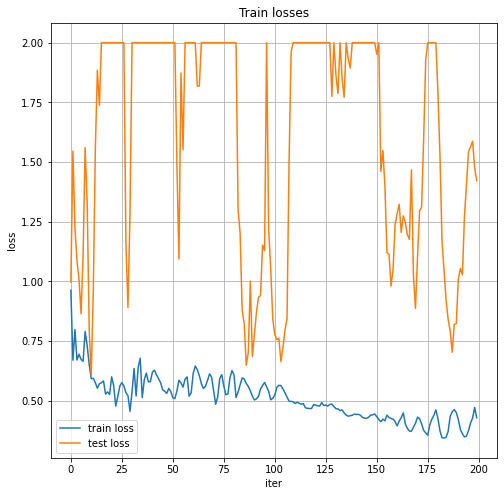

In [344]:
criterion = get_criterion(train_ds, 'kl', device, gamma=1.4)
model = EfficientNetASR('b1').to(device)
#model = CNN_blstm().to(device)
model = train_per_chunk(model, 
                        train_dl, dev_dl,  # egs_list=['028_2016-04-06_Nottingham']
                        epochs=200, 
                        lr=1e-4,
                        weight_decay=1e-4, 
                        gamma=1,
                        device=device, 
                        criterion=criterion)
torch.save(model, 'models/it3/effnet.tmp.pt')
# train= val=0.01172. btz=40, epochs=60, lr=1e-4
# train= val=0.01155. btz=128, epochs=60, lr=1e-4
# train= val=. btz=128, epochs=60, lr=1e-3
# train= val=. btz=128, epochs=60, lr=1e-5
# mse^2 train= val=0.01417. btz=128, epochs=60, lr=1e-3


In [113]:
# criterion = get_criterion(train_cls_ds, 'focal', device)
# model = EfficientNetASR('b1').to(device)
# #model = CNN_blstm().to(device)
# model = train_per_chunk(model, 
#                         train_dl, test_dl,  # egs_list=['028_2016-04-06_Nottingham']
#                         epochs=200, 
#                         lr=1e-4,
#                         weight_decay=1e-6, 
#                         gamma=1,
#                         device=device, 
#                         criterion=criterion)
# torch.save(model, 'models/it2/effnet.focal.pt')

In [352]:
model = torch.load('models/model.best.pt')

In [353]:
loss, cr, conf = eval_cls(model, train_dl, device=device)
print("!!!TRAIN!!!")
print(f'{loss=}')
print(cr)
print(conf)

!!!TRAIN!!!
loss=0.680525012811025
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00        10
          l2       0.00      0.00      0.00         4
          l3       0.69      0.38      0.49       907
          l4       0.51      0.84      0.63       824
          l5       0.00      0.00      0.00       110

    accuracy                           0.56      1855
   macro avg       0.24      0.24      0.22      1855
weighted avg       0.56      0.56      0.52      1855

[[  0   0   7   3   0]
 [  0   0   1   3   0]
 [  0   0 346 561   0]
 [  0   0 134 690   0]
 [  0   0  16  94   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [354]:
loss, cr, conf = eval_cls(model, dev_dl, device=device)
print(f'{loss=}')
print(cr)
print(conf)

loss=0.5998521596193314
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         6
          l2       0.00      0.00      0.00         5
          l3       0.15      0.07      0.10       113
          l4       0.56      0.91      0.70       383
          l5       0.00      0.00      0.00       168

    accuracy                           0.53       675
   macro avg       0.14      0.20      0.16       675
weighted avg       0.34      0.53      0.41       675

[[  0   0   1   5   0]
 [  0   0   0   5   0]
 [  0   0   8 105   0]
 [  0   0  33 350   0]
 [  0   0  11 157   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [355]:
#model = torch.load('models/it3/effnet.tmp.pt')

loss, cr, conf = eval_cls(model, test_dl, device=device)
print(f'{loss=}')
print(cr)
print(conf)

loss=0.7004139026006063
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         5
          l2       0.00      0.00      0.00         4
          l3       0.38      0.42      0.40        93
          l4       0.70      0.75      0.73       226
          l5       0.00      0.00      0.00        16

    accuracy                           0.61       344
   macro avg       0.22      0.23      0.23       344
weighted avg       0.56      0.61      0.59       344

[[  0   0   1   4   0]
 [  0   0   3   1   0]
 [  0   0  39  54   0]
 [  0   0  56 170   0]
 [  0   0   3  13   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [356]:

model = torch.load('models/model.best.pt')
loss, cr, conf = eval_cls(model, test_dl, device=device)
print(f'{loss=}')
print(cr)
print(conf)
# 0.013951944429427385

loss=0.699528694152832
              precision    recall  f1-score   support

          l1       0.00      0.00      0.00         5
          l2       0.00      0.00      0.00         4
          l3       0.34      0.33      0.34        93
          l4       0.69      0.77      0.73       226
          l5       0.00      0.00      0.00        16

    accuracy                           0.60       344
   macro avg       0.21      0.22      0.21       344
weighted avg       0.55      0.60      0.57       344

[[  0   0   1   4   0]
 [  0   0   4   0   0]
 [  0   0  31  62   0]
 [  0   0  51 175   0]
 [  0   0   4  12   0]]


/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/hdd/mitrofanov-aa/project/study/anaconda/envs/sr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [ ]:
#for idx in random_idxes:
ipd.display(ipd.Audio(item['expert_wav'][0, :25*chk_len*16], rate=16000))